In [1]:
import torch
import torchphysics as tp
import numpy as np
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
Re = tp.spaces.R1("re")
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')
P=tp.spaces.R1('p')
F_X = tp.spaces.R1('fx')
F_Y = tp.spaces.R1('fy')

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.device_count()

0

In [3]:
X_interval = tp.domains.Interval(X, 0, 4.0) # <-add the bounds of the Interval (0, 2)
Y_interval = tp.domains.Interval(Y, 0, 2.0)
Re_interval = tp.domains.Interval(Re, 0, 2)
Sim_domain = X_interval*Y_interval*Re_interval


In [4]:

bound_sampler_low = tp.samplers.RandomUniformSampler(Y_interval.boundary_left*X_interval*Re_interval, n_points=250)

bound_sampler_up = tp.samplers.RandomUniformSampler(Y_interval.boundary*X_interval*Re_interval, n_points=1000)


In [5]:
def IBM_filter(y,x,re):
    return (y[...,0]<=torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]+0.15) | (y[...,0]>=2-torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]-0.15)
    
IBM_sampler = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter)

In [6]:
def IBM_filter_2(y,x,re):
    return ((y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]+0.1) & (y[...,0]<=torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]+0.15)) | ((y[...,0]<2-torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]-0.1) & (y[...,0]>=2-torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]-0.15))
    
IBM_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter_2)

In [7]:
def Inner_filter(y,x,re):
    return (y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]+0.15) | (y[...,0]<2-torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]-0.15) 

inner_sampler = tp.samplers.RandomUniformSampler(Sim_domain, n_points=2000,filter_fn=Inner_filter)

In [8]:
def Inner_filter_2(y,x,re):
    return (y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]+0.15)&(y[...,0]<0.1*re[...,0]+0.2) | (y[...,0]<2-torch.sin(x[...,0]*np.pi*2)*0.1*re[...,0]-0.15)&(y[...,0]>2-0.1*re[...,0]-0.2)

inner_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain, n_points=1000,filter_fn=Inner_filter_2)

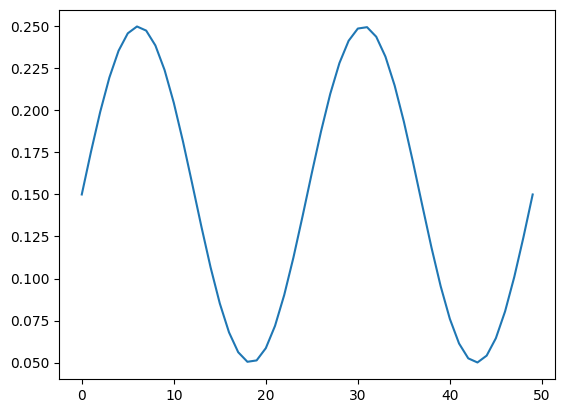

In [9]:
b=np.sin(np.linspace(0,2)*3.1415926*2)/10+0.15
import matplotlib.pyplot as plt
plt.plot(b)

In [10]:
model = tp.models.FCN(input_space=X*Y*Re, output_space=U*V*P, hidden=(80,80,80,80,80,80,80,80),activations=tp.models.Sinus())
#######Activation????

In [11]:
#import torch.nn as nn
#import torch.nn.functional as F
#class FCN_model(nn.Module):
#    def __init__(self,input_space,output_space):
#        super().__init__()
#        self.output_space=output_space
#        self.fcbridge=nn.Linear(in_features=input_space.dim,out_features=80)
#        self.fc1=nn.Linear(in_features=input_space.dim,out_features=80)
#        self.fc2=nn.Linear(in_features=80,out_features=80)
#        self.fc3=nn.Linear(in_features=80,out_features=80)
#        self.fc4=nn.Linear(in_features=80,out_features=80)
#        self.fc5=nn.Linear(in_features=80,out_features=80)
#        self.fc5=nn.Linear(in_features=80,out_features=80)
#        self.fc6=nn.Linear(in_features=80,out_features=80)#
#        self.fc7=nn.Linear(in_features=80,out_features=80#)
#        self.out=nn.Linear(in_features=80,out_features=out#put_space.dim)
#    def forward(self,t):
#        t_bridge=F.tanh(self.fc1(t))
#        t=F.tanh(self.fc1(t))
#        t=F.tanh(self.fc2(t))
#        t=F.tanh(self.fc3(t))
#        t=F.tanh(self.fc4(t))
#        t=F.tanh(self.fc5(t))
#        t=F.tanh(self.fc6(t))
#        t=F.tanh(self.fc7(t))
#        t=self.out(F.tanh(t+t_bridge))
#        return tp.problem.spaces.Points(t, self.output_space)
        
#model=FCN_model(input_space=X*Y*Re,output_space=U*V*P)

In [12]:
#tp.scatter(X*Y,IBM_sampler)

In [13]:
inte_sampler = tp.samplers.RandomUniformSampler(X_interval.boundary*Y_interval, n_points=250)
x_inlet_sampler=tp.samplers.RandomUniformSampler(X_interval*Y_interval,n_points=250)

In [14]:
def init_bulk(u_integral,x_integral,y_integral):
    return u_integral-1
pde_cond_bulk=tp.conditions.IntegroPINNCondition(model,x_inlet_sampler,init_bulk,inte_sampler, weight=1)

In [15]:
def pde_IBM(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM = tp.conditions.PINNCondition(model, IBM_sampler, pde_IBM,weight=100,name='IBM')

In [16]:
def pde_IBM_p(p):
    return p
pde_cond_IBM_p = tp.conditions.PINNCondition(model, IBM_sampler, pde_IBM_p,weight=100,name='IBM_p')

In [17]:
def pde_IBM_2(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM_2 = tp.conditions.PINNCondition(model, IBM_sampler_2, pde_IBM_2,weight=100,name='IBM_2')

In [18]:
def pde_mass(u,v,x,y):
    return tp.utils.grad(u,x)+tp.utils.grad(v,y)-0.0
pde_cond_mass = tp.conditions.PINNCondition(model, inner_sampler, pde_mass,weight=50,name='Conti')

In [19]:
def pde_residual_x(u,v, x, y,re,p):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/1000 - 1+tp.utils.grad(p,x)
    return residual_momentum

pde_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_x, pde_IBM,weight=50,name='Momentum_x')

In [20]:
def pde_residual_x_2(u,v, x, y,re,p):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/1000 - 1+tp.utils.grad(p,x)
    return residual_momentum

pde_cond_x_2 = tp.conditions.PINNCondition(model, inner_sampler_2, pde_residual_x_2, pde_IBM,weight=50,name='Momentum_x_2')

In [21]:
def pde_residual_x_2(u,v, x, y,re,p):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/1000 - 1+tp.utils.grad(p,x)
    return residual_momentum

pde_cond_x_2 = tp.conditions.PINNCondition(model, inner_sampler_2, pde_residual_x_2, pde_IBM,weight=50,name='Momentum_x_2')

In [22]:
def pde_residual_y_2(u,v, x, y,re,p):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/1000+tp.utils.grad(p,y)
    return residual_momentum

pde_cond_y_2 = tp.conditions.PINNCondition(model, inner_sampler_2, pde_residual_y_2, pde_IBM,weight=10,name='Momentum_y_2')

In [23]:
def pde_residual_y(u,v, x, y,re,p):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/1000+tp.utils.grad(p,y)
    return residual_momentum

pde_cond_y = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_y, pde_IBM,weight=10,name='Momentum_y')

In [24]:
def pde_residual_poisson(u,v, x, y,re,p):
    residual_poisson= tp.utils.laplacian(p,u)+tp.utils.laplacian(p,v)+ tp.utils.grad(tp.utils.grad(u*v,y),x)+tp.utils.grad(tp.utils.grad(u*u,x),x)+tp.utils.grad(tp.utils.grad(u*v,y),x)+tp.utils.grad(tp.utils.grad(v*v,y),y)
    return residual_poisson


Poisson_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_poisson, pde_IBM,weight=50,name='Poisson_x')

In [25]:
def boundary_residual(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))

boundary_cond = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual, weight=10,name='noslip')

In [26]:
def boundary_residual_x(u, x,y):
    return u - 0.0

boundary_cond_x = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_x, weight=1,name='noslip_x')

In [27]:
def boundary_residual_y(v, x,y):
    return v - 0.0

boundary_cond_y = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_y, weight=1,name='noslip_y')

In [28]:
Periodic_sampler=tp.samplers.RandomUniformSampler(Y_interval*Re_interval,n_points=2000)

In [29]:
def periodic_residual(u_left,u_right,v_left,v_right):
    Periodic_condition= torch.sqrt(torch.square(u_left)+torch.square(v_left)) - torch.sqrt(torch.square(u_right)+torch.square(v_right))
    return Periodic_condition
periodic_cond=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual,non_periodic_sampler=Periodic_sampler, weight=100,name='periodic')

In [30]:
def periodic_residual_p(p_left,p_right):
    Periodic_condition= p_left-p_right
    return Periodic_condition
periodic_cond_p=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_p,non_periodic_sampler=Periodic_sampler, weight=100,name='periodic_p')

In [31]:
def periodic_residual_x(u_left,u_right):
    Periodic_condition= u_left - u_right
    return Periodic_condition
periodic_cond_x=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_x,non_periodic_sampler=Periodic_sampler, weight=50,name='periodic_x')

In [32]:
def periodic_residual_y(v_left,v_right):
    Periodic_condition= v_left - v_right
    return Periodic_condition
periodic_cond_y=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_y,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_y')

In [33]:
bound_sampler_left = tp.samplers.RandomUniformSampler(X_interval.boundary_left*Y_interval*Re_interval, n_points=250)
def boundary_residual_p(p, x,y):
    return p

boundary_cond_p = tp.conditions.PINNCondition(model, bound_sampler_left, boundary_residual_p, weight=1,name='bound_p')


In [34]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001,scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,scheduler_args={"patience":1000,"factor":0.8,"verbose":True,"min_lr":0.000005},monitor_lr="train/loss")
#solver = tp.solver.Solver([pde_cond_IBM,pde_cond_mass,boundary_cond_x, pde_cond_x,periodic_cond_x,boundary_cond_y, pde_cond_y,periodic_cond_y], optimizer_setting=optim)
#optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([pde_cond_IBM,#1000
                           pde_cond_IBM_2,#1000
                           pde_cond_IBM_p,
                           boundary_cond,#1000
                           #boundary_cond_p,
                           periodic_cond_x,#2000
                           periodic_cond_p,
                           pde_cond_x,#5000
                           pde_cond_y,#5000
                           pde_cond_mass,#5000
                           pde_cond_x_2,#1000
                           pde_cond_y_2],#1000
                          optimizer_setting=optim,
                         loss_function_schedule=[{
                        "conditions":[0,1,2,3,4,5],
                        "max_iter":4000
                    }
                ],
                          weight_tunning=True,
                          weight_tunning_parameters={
                                    "alfa":0.99,
                                    "E_rho":0.99,
                                    "Temperature":0.1,
                                    "tunning_every_n_steps":100
                          } ## Default weight-tunning settings
                         )

In [35]:
torch.set_float32_matmul_precision('medium')


In [36]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
comet_logger = pl_loggers.CSVLogger(save_dir="logs_sin/")
trainer = pl.Trainer(gpus=0,# use one GPU
                     max_steps=20000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=comet_logger, # for writting into tensorboard
                     enable_checkpointing=False      ) # saving checkpoints
trainer.fit(solver)

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:273: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'patience', 'factor', 'min_lr', 'verbose'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 45.9 K
1 | val_conditions   | ModuleList | 0     
------------

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|████████████████████████▉| 20000/20001 [1:54:24<00:00,  2.91it/s, loss=14.8, v_num=20]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████████████████| 20001/20001 [1:54:24<00:00,  2.91it/s, loss=14.8, v_num=20]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|█████████████████████████| 20001/20001 [1:54:24<00:00,  2.91it/s, loss=14.8, v_num=20]


In [37]:
import matplotlib.pyplot as plt

In [38]:
plt.close()

In [51]:
def produce_sample(x_max,y_max,other_Constrains,resolution=40):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(0,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)
    model_value_p=np.zeros(XM.shape)

    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j],other_Constrains]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,1]
            model_value_p[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,2]
    model_value_x=np.transpose(model_value_x)
    model_value_y=np.transpose(model_value_y)
    model_value_p=np.transpose(model_value_p)
    plt.contourf(XM,YM,model_value_x)
    color=np.sqrt(np.square(model_value_x)+np.square(model_value_y))
    color=model_value_x
    #plt.quiver(XM,YM,model_value_x,model_value_y,color,headlength=2,headwidth=5)
   # plt.streamplot(XM,YM,model_value_y,model_value_x)
    plt.colorbar(label="U")
    x=np.linspace(0,x_max)
    y=np.sin(x*2*np.pi)*0.1*other_Constrains+0.15
    y2=2-np.sin(x*2*np.pi)*0.1*other_Constrains-0.15
    plt.plot(x,y,"r")
    plt.plot(x,y2,"r")
    return model_value_x


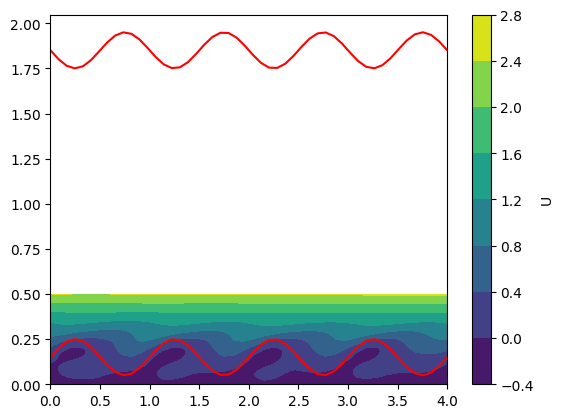

In [60]:
model_values=produce_sample(4,0.5,1)


In [53]:
def produce_sample_p(x_max,y_max,other_Constrains,resolution=40):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(0,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)
    model_value_p=np.zeros(XM.shape)

    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j],other_Constrains]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,1]
            model_value_p[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,2]
    model_value_x=np.transpose(model_value_x)
    model_value_y=np.transpose(model_value_y)
    model_value_p=np.transpose(model_value_p)
    plt.contourf(XM,YM,model_value_p)
    color=np.sqrt(np.square(model_value_x)+np.square(model_value_y))
    color=model_value_x
    #plt.quiver(XM,YM,model_value_x,model_value_y,color,headlength=2,headwidth=5)
   # plt.streamplot(XM,YM,model_value_y,model_value_x)
    plt.colorbar(label="p")
    x=np.linspace(0,x_max)
    y=np.sin(x*2*np.pi)*0.1*other_Constrains+0.15
    y_up=2-(np.sin(x*2*np.pi)*0.1*other_Constrains+0.15)
    plt.plot(x,y,"r")
    plt.plot(x,y_up,"r")
    
    return model_value_x

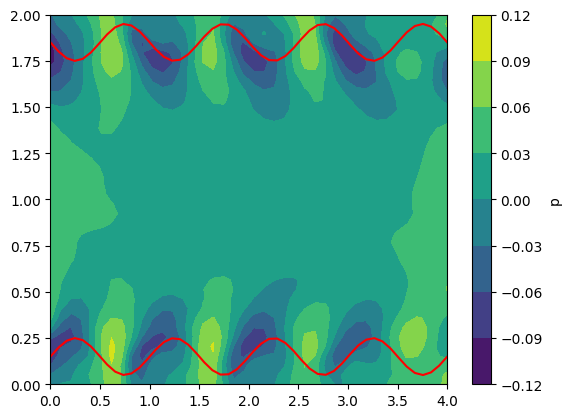

In [54]:
model_values=produce_sample_p(4,2,1)


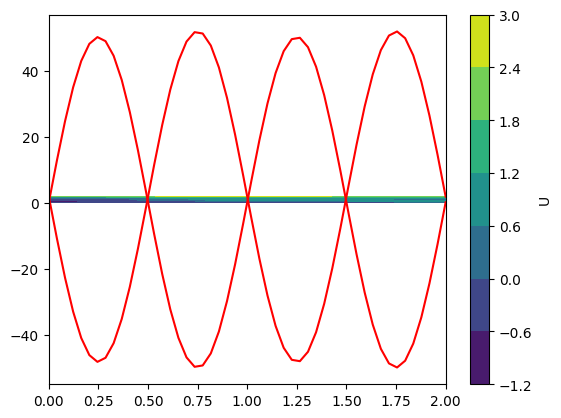

In [43]:
model_values=produce_sample(2,2,500)


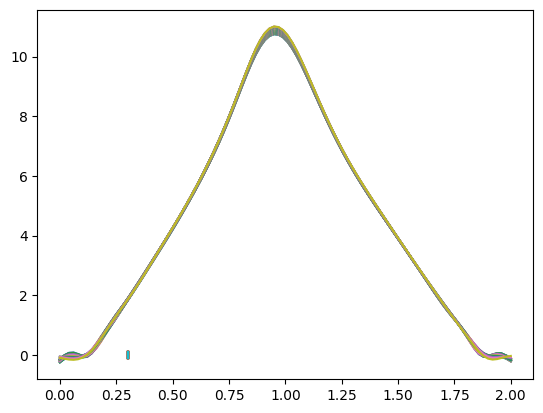

In [56]:
for j in np.linspace(0,4,40):
    coords = torch.tensor([[j,i,2] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

In [45]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,20] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

NameError: name 'H' is not defined

In [ ]:
coords = torch.tensor([[5,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))
coords = torch.tensor([[0,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))